In [1]:
import numpy as np
import pandas as pd
import os
import socket
import platform
from pathlib import Path
import time
import glob
import re
import gc
import shutil

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask.distributed import as_completed
from IPython.display import IFrame
from ClusterWrap.clusters import janelia_lsf_cluster

from tqdm.notebook import tqdm

from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.linear_model import (LinearRegression,
                                  TheilSenRegressor,
                                  RANSACRegressor,
                                  HuberRegressor,
                                  RidgeCV,
                                  LassoCV)
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

import mrcfile
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

from FIBSEM_gs_py.FIBSEM_gs import FIBSEM_frame, FIBSEM_dataset

from FIBSEM_gs_py.FIBSEM_gs import (get_min_max_thresholds,
                        get_spread,
                        check_DASK,
                        show_eval_box_mrc_stack,
                        analyze_mrc_stack_registration,
                        generate_report_from_xls_registration_summary,
                        plot_registrtion_quality_xlsx,
                        destreak_mrc_stack_with_kernel,
                        destreak_single_frame_kernel_shared,
                        smooth_mrc_stack_with_kernel,
                        bin_crop_mrc_stack,
                        mrc_stack_estimate_resolution_blobs_2D,
                        mrc_stack_plot_2D_blob_examples,
                        plot_cross_sections_mrc_stack,
                        plot_2D_blob_results,
                        plot_2D_blob_examples)

from skimage import __version__ as skimage_version
print('skimage version: ', skimage_version)
from scipy import __version__ as scipy_version
print('scipy version:   ', scipy_version)
from sklearn import __version__ as sklearn_version
print('sklearn version: ', sklearn_version)
from cv2 import __version__ as cv2_version
print('Open CV version: ', cv2_version)
from FIBSEM_gs_py import __version__ as FIBSEM_gs_py_version
print('FIBSEM_gs_py version: ', FIBSEM_gs_py_version)

RuntimeError: Unable to load FIBSEM_help_functions_gs

# This Notebook shows examples of workflow using already registered MRC stacks
### - setting/checking Evaluation Box
### - performing Registration Analysis
### - comparing the results of Different Registrations

# Set up DASK client

In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\distributed\bokeh\core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Using Local Port:    57132


# Set / Show Evaluation Box

Wall time: 13.8 s


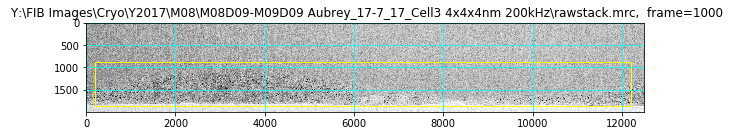

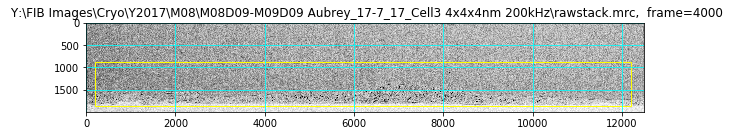

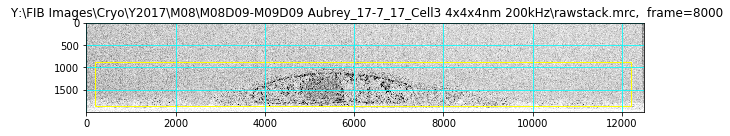

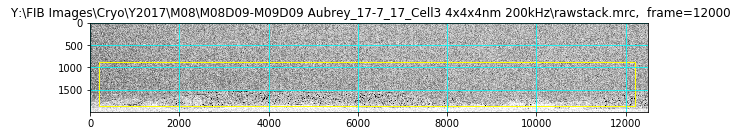

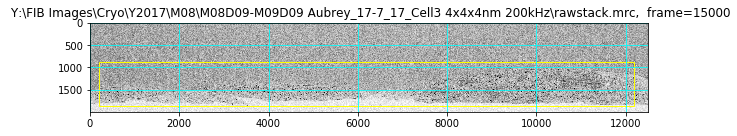

In [4]:
%%time
data_dir = 'Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz'
rawstack_mrc = os.path.join(data_dir, 'rawstack.mrc')
evaluation_box=[875,1000,200, 12000]
show_eval_box_mrc_stack(rawstack_mrc,
                            evaluation_box=evaluation_box,
                           frame_inds = [1000, 4000, 8000, 12000, 15000])

# Analyze the quality of Stack Registration

DASK client exists. Will perform distributed computations
Use http://localhost:57132/status to monitor DASK progress
Will use fixed evaluation box:  [875, 1000, 200, 12000]
mrc_mode=6  , dt_mrc= <class 'numpy.uint16'>
Will analyze regstrations in 16867 frames
Will save the data into Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RawStack_withEB_RegistrationQuality.xlsx
Using DASK distributed
Saving the Registration Quality Statistics into the file:  Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RawStack_withEB_RegistrationQuality.xlsx


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Wall time: 1h 28min 50s


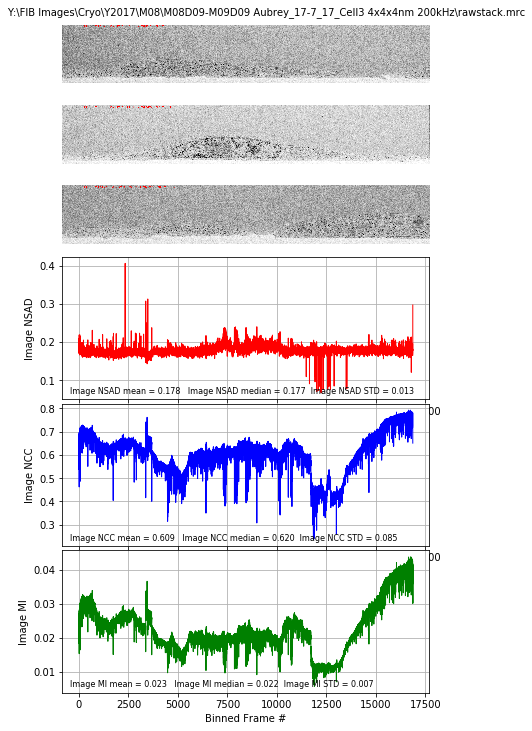

In [5]:
%%time
data_dir = 'Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz'
rawstack_mrc = os.path.join(data_dir, 'rawstack.mrc')
evaluation_box=[875,1000,200, 12000]
save_filename = os.path.join(data_dir, 'RawStack_withEB.mrc')
reg_results_rawstack = analyze_mrc_stack_registration(rawstack_mrc,
                                                      DASK_client = client,
                                                      evaluation_box = evaluation_box,
                                                      save_filename = save_filename)
generate_report_from_xls_registration_summary(reg_results_rawstack[1])

DASK client exists. Will perform distributed computations
Use http://localhost:57132/status to monitor DASK progress
Will use fixed evaluation box:  [300, 1000, 200, 12000]
mrc_mode=6  , dt_mrc= <class 'numpy.uint16'>
Will analyze regstrations in 16867 frames
Will save the data into Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\SIFTalignTrans-16bit-rot_0_0_6_withEB_RegistrationQuality.xlsx
Using DASK distributed
Saving the Registration Quality Statistics into the file:  Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\SIFTalignTrans-16bit-rot_0_0_6_withEB_RegistrationQuality.xlsx
Wall time: 1h 20min 57s


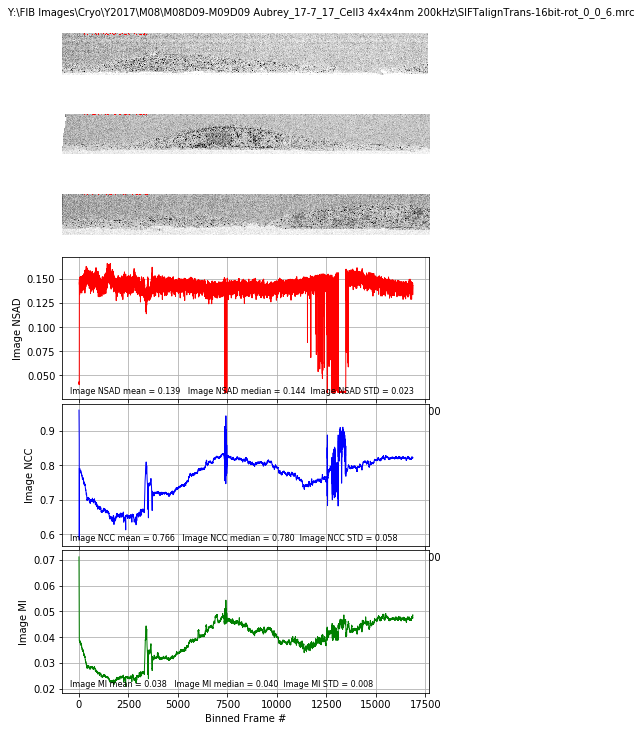

In [6]:
%%time
data_dir = 'Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz'
evaluation_box=[300,1000,200, 12000]
orig_rot_mrc = os.path.join(data_dir, 'SIFTalignTrans-16bit-rot_0_0_6.mrc')
save_filename = os.path.join(data_dir, 'SIFTalignTrans-16bit-rot_0_0_6_withEB.mrc')
reg_results_orig_mrc_rot = analyze_mrc_stack_registration(orig_rot_mrc,
                                                          DASK_client = client,
                                                          evaluation_box = evaluation_box,
                                                          save_filename = save_filename)
generate_report_from_xls_registration_summary(reg_results_orig_mrc_rot[1])

DASK client exists. Will perform distributed computations
Use http://localhost:57132/status to monitor DASK progress
Will use fixed evaluation box:  [1100, 1000, 200, 12000]
mrc_mode=1  , dt_mrc= <class 'numpy.int16'>
Will analyze regstrations in 16867 frames
Will save the data into Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RegularizedAffineTransform_withEB0_RegistrationQuality.xlsx
Using DASK distributed
Saving the Registration Quality Statistics into the file:  Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RegularizedAffineTransform_withEB0_RegistrationQuality.xlsx
Wall time: 1h 21min 54s


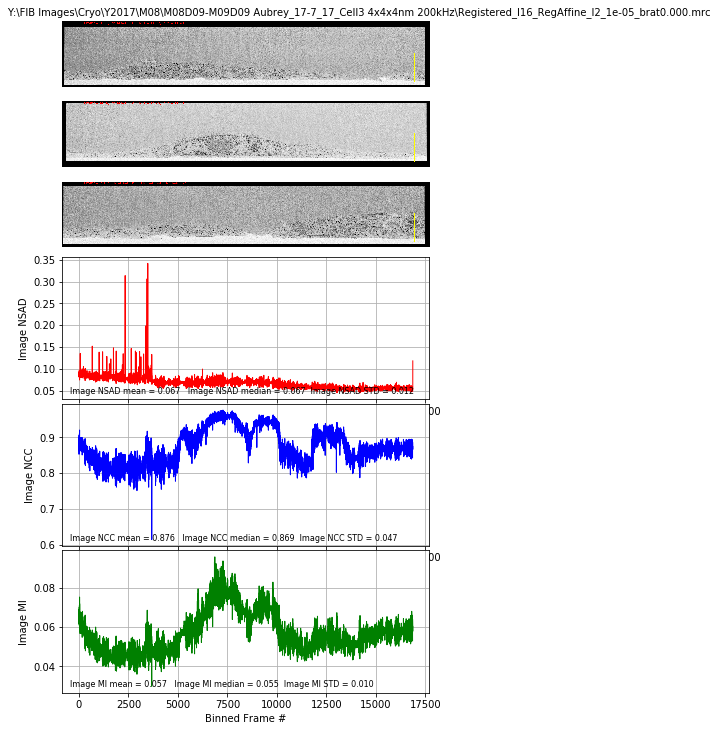

In [11]:
%%time
evaluation_box=[1100,1000,200, 12000]
RegularizedAffine_mrc = os.path.join(data_dir, 'Registered_I16_RegAffine_l2_1e-05_brat0.000.mrc')
save_filename = os.path.join(data_dir, 'RegularizedAffineTransform_withEB0.mrc')
reg_results_RegularizedAffine_EB0 = analyze_mrc_stack_registration(RegularizedAffine_mrc,
                                                                   DASK_client = client,
                                                                   evaluation_box = evaluation_box,
                                                                   save_filename = save_filename)
generate_report_from_xls_registration_summary(reg_results_RegularizedAffine_EB0[1])

DASK client exists. Will perform distributed computations
Use http://localhost:57132/status to monitor DASK progress
Will use fixed evaluation box:  [1100, 1000, 200, 12000]
mrc_mode=1  , dt_mrc= <class 'numpy.int16'>
Will analyze regstrations in 16867 frames
Will save the data into Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RegularizedAffineTransform_b040_withEB0_RegistrationQuality.xlsx
Using DASK distributed
Saving the Registration Quality Statistics into the file:  Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\RegularizedAffineTransform_b040_withEB0_RegistrationQuality.xlsx
Wall time: 1h 22min 1s


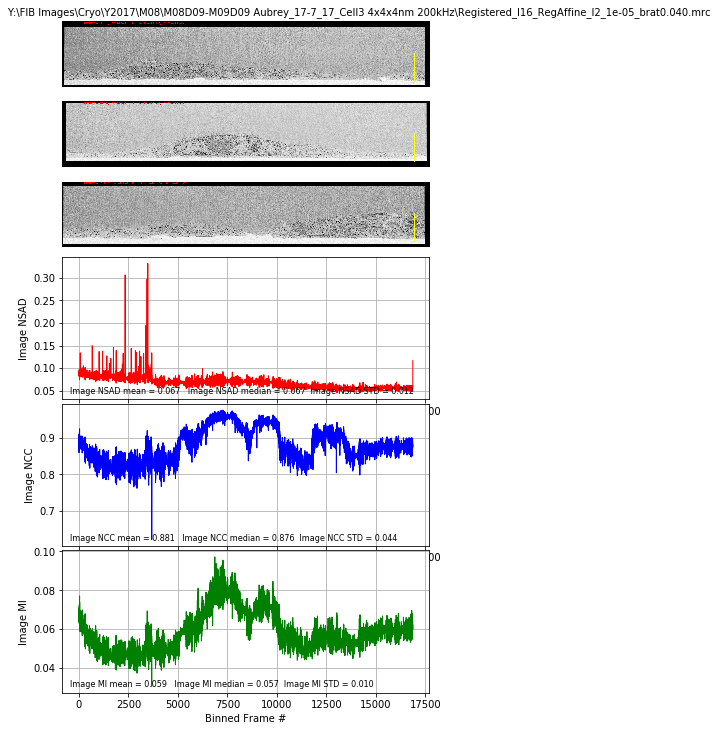

In [12]:
%%time
evaluation_box=[1100,1000,200, 12000]
RegularizedAffine_b040_mrc = os.path.join(data_dir, 'Registered_I16_RegAffine_l2_1e-05_brat0.040.mrc')
save_filename = os.path.join(data_dir, 'RegularizedAffineTransform_b040_withEB0.mrc')
reg_results_RegularizedAffine_b040_EB0 = analyze_mrc_stack_registration(RegularizedAffine_b040_mrc,
                                                                        DASK_client = client,
                                                                        evaluation_box = evaluation_box,
                                                                        save_filename = save_filename)
generate_report_from_xls_registration_summary(reg_results_RegularizedAffine_b040_EB0[1])

# Compare Different Registrations

generating the registration quality summary plots:   0%|          | 0/4 [00:00<?, ?it/s]

saving the data into xlsx file:   0%|          | 0/4 [00:00<?, ?it/s]

'Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz\\Regstration_Summary_EB0_HeLa3.xlsx'

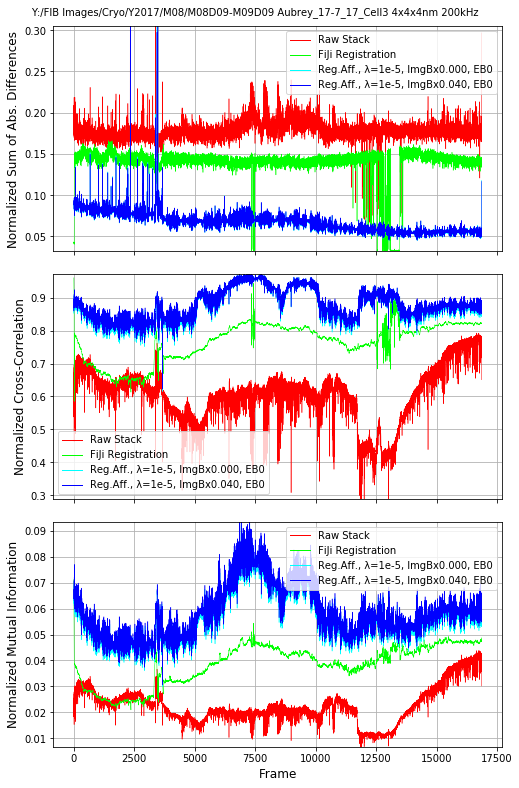

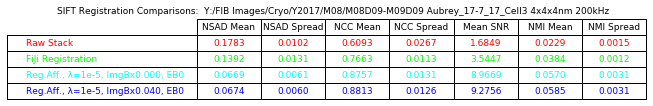

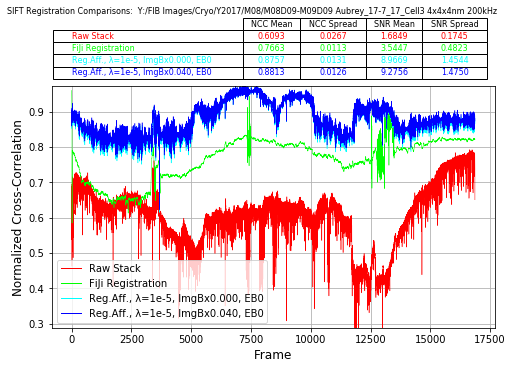

In [16]:
data_dir = 'Y:/FIB Images/Cryo/Y2017/M08/M08D09-M09D09 Aubrey_17-7_17_Cell3 4x4x4nm 200kHz'
reg_qual_fls = [reg_results_rawstack[1],
              reg_results_orig_mrc_rot[1],
              reg_results_RegularizedAffine_EB0[1],
              reg_results_RegularizedAffine_b040_EB0[1]]

pfs = ['Raw Stack',
      'FiJi Registration',
      'Reg.Aff., λ=1e-5, ImgBx0.000, EB0',
      'Reg.Aff., λ=1e-5, ImgBx0.040, EB0']

save_filename=os.path.join(data_dir, 'Regstration_Summary_EB0_HeLa3.png')
plot_registrtion_quality_xlsx(reg_qual_fls, pfs,
                              save_filename = save_filename,
                              colors = ['red', 'lime', 'cyan', 'blue'])